In [1]:
import importlib
import helper_fxns as hf
import os
import numpy as np
import pandas as pd
import pyelastix
import spect_fxns as sf
import skimage.feature
import skimage.transform
%matplotlib inline

In [22]:
importlib.reload(hf)
importlib.reload(sf)

<module 'spect_fxns' from 'C:\\Users\\Clinton\\Documents\\spect-assessment\\spect_fxns.py'>

In [27]:
def reg_all_niis(patient_id, nii_paths, verbose=True):
    if verbose:
        print("\n"+str(patient_id))
    patient_nii_paths = nii_paths[patient_id]
    base_dir = patient_nii_paths['base']
    temp_file = "Z:\\temp.nii"
    
    blmri_art, _ = hf.ni_load(patient_nii_paths["blmri-art"])
    
    if verbose:
        print("Registering BL MRI (pre) to BL MRI (arterial)")
    sf.reg_niis("blmri-art", "blmri-pre", patient_nii_paths, fixed_img=blmri_art)
    
    if verbose:
        print("Registering FU MRI to BL MRI (arterial)")
    _, blfu_transform_path = sf.reg_niis("blmri-art", "fumri-art", patient_nii_paths, fixed_img=blmri_art)
    
    if verbose:
        print("Registering FU MRI (pre) to FU MRI (arterial)")
    if not sf.reg_niis("fumri-art", "fumri-pre", patient_nii_paths, out_img_path=temp_file, overwrite=True) is None:
        if verbose:
            print("Transforming FU MRI (pre) to BL MRI coords")
        sf.transform_niis(temp_file, [blfu_transform_path], patient_nii_paths, out_img_path=base_dir+"fumri-pre-reg.nii")
            
    if verbose:
        print("Registering CT to BL MRI")
    _, blct_transform_path = sf.reg_niis("blmri-art", "ct", patient_nii_paths, fixed_img=blmri_art)

    if verbose:
        print("Registering Fused to CT")
    _, ctfused_transform_path = sf.reg_niis("ct", "fused-ch1", patient_nii_paths, out_img_path=temp_file, overwrite=True)
    if verbose:
        print("Transforming Fused to BL MRI coords")
    sf.transform_niis(temp_file, [blct_transform_path], patient_nii_paths, out_img_path=base_dir+"fused-reg.nii")

    if verbose:
        print("Registering SPECT to Fused")
    sf.reg_niis("fused-ch1", "spect", patient_nii_paths, out_img_path=temp_file, overwrite=True)
    if verbose:
        print("Transforming SPECT to BL MRI coords")
    sf.transform_niis(temp_file, [ctfused_transform_path], patient_nii_paths, out_img_path=temp_file, overwrite=True)
    sf.transform_niis(temp_file, [blct_transform_path], patient_nii_paths, out_img_path=base_dir+"spect-reg.nii")

    os.remove(temp_file)

In [2]:
xls_fn = r"Z:\Isa\T1-Response-Desktop.xlsx"
writer = pd.ExcelWriter(xls_fn)

df = pd.read_excel(xls_fn, index_col=0, dtype={"index": np.int32})
df.dropna(subset=["high thresh"], inplace=True)
df = df[df["Segmented"] == "Yes"]
patient_ids = df.index.values


patient_id = 3

In [9]:
for patient_id in patient_ids:
    sf.check_dcm_paths(patient_id, df)

In [3]:
dcm_paths = {}
nii_paths = {}
mask_paths = {}

for patient_id in patient_ids:
    sf.set_paths(patient_id, df, dcm_paths, nii_paths, mask_paths)

In [27]:
for patient_id in patient_ids:
    sf.save_niis(patient_id, dcm_paths, nii_paths)

In [28]:
for patient_id in patient_ids:
    reg_all_niis(patient_id, nii_paths)


3
Registering BL MRI (pre) to BL MRI (arterial)
blmri-art and blmri-pre have the same shape. Skipping registration.
Registering FU MRI to BL MRI (arterial)
Registering FU MRI (pre) to FU MRI (arterial)
fumri-art and fumri-pre have the same shape. Skipping registration.
Registering CT to BL MRI
Registering Fused to CT
Transforming Fused to BL MRI coords
Registering SPECT to Fused
Transforming SPECT to BL MRI coords

5
Registering BL MRI (pre) to BL MRI (arterial)
blmri-art and blmri-pre have the same shape. Skipping registration.
Registering FU MRI to BL MRI (arterial)
Registering FU MRI (pre) to FU MRI (arterial)
fumri-art and fumri-pre have the same shape. Skipping registration.
Registering CT to BL MRI
Registering Fused to CT
Transforming Fused to BL MRI coords
Registering SPECT to Fused
Transforming SPECT to BL MRI coords

16
Registering BL MRI (pre) to BL MRI (arterial)
blmri-art and blmri-pre have the same shape. Skipping registration.
Registering FU MRI to BL MRI (arterial)
Regi

In [ ]:
def reg_masks(patient_id, nii_paths, verbose=True):
    if verbose:
        print("Transforming FU MRI masks to BL MRI coords")
        
    if verbose:
        print("Transforming SPECT mask to BL MRI coords")

In [93]:
ttt, _ = hf.ni_load(patient_nii_paths["fused-ch1-reg"])

In [18]:
x,_ = hf.ni_load(base_dir+"fused-reg.nii")
x.shape

(320, 250, 72)

In [19]:
x,_ = hf.ni_load(base_dir+"spect-reg.nii")
x.shape

(320, 250, 72)

In [85]:
reg_niis("blmri-art", "ct", nii_paths[patient_id], fixed_img=blmri_art, overwrite=True)

True

In [103]:
test, _ = hf.ni_load("test.nii")

In [ ]:
transform_niis(patient_nii_paths["fused-ch1"], ["ct_blmri-art"], nii_paths[patient_id], [blmri_art])

In [104]:
test.shape

(320, 250, 72)

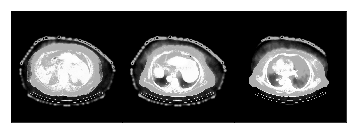

In [108]:
hf.plot_section_auto(test)

fumri_bl, _ = hf.dcm_load(dcm_paths[patient_id]['fumri-pre'])
fumri_bl = hf.reg_imgs(moving=fumri_bl, fixed=blmri_img, params=reg_params)
save_nii(fumri_bl, nii_paths[patient_id]["fumri-pre"])

In [ ]:
#spect_header = hf.get_spect_series(dcm_paths[patient_id]['spect'], just_header=True)
#rows = spect_header[('0028', '0010')].value
#cols = spect_header[('0028', '0011')].value
#frames = spect_header[('0028', '0008')].value

#print(patient_id, rows*cols*frames)
#df["voxels"] = 

In [207]:
df.to_excel(writer, sheet_name="Updated")
writer.save()

In [ ]:
for i in [3,5,14,15,16,24,28,29,34,20,21,22,23]: #os.listdir('Z:\\Isa')
    if str(df.loc[i]["SPECT"]) == "nan":
        continue
    spect_dir = 'Z:\\Isa\\spect\\' + str(df.loc[i]["SPECT"])
    for fn in os.listdir(spect_dir):
        if 'recon - ac' in fn:
            dcm_paths[patient_id]['spect'] = spect_dir + "\\" + fn
            print("found",i)
            spect_header = get_spect_series(dcm_paths[patient_id]['spect'], just_header=True)
            df.loc[i,'SPECT-Slope'] = spect_header[('0028', '1051')].value
            continue
        elif 'y90 sirs' in fn and 'ac' not in fn:
            dcm_paths[patient_id]['ct'] = spect_dir + "\\" + fn
        elif 'fused trans' in fn:
            dcm_paths[patient_id]['fused'] = spect_dir + "\\" + fn

In [91]:
mask_file = mask_paths[patient_id]["necrosis-fu"]

In [95]:
orig_dims = fumri_img.shape

In [92]:
dims = blmri_bl.shape

fn_base = mask_file[:mask_file.find('.')]

with open(mask_file, 'rb') as f:
    mask = f.read()
    mask = np.fromstring(mask, dtype='uint8')
    mask = np.array(mask).reshape(orig_dims[::-1])
    mask = np.transpose(mask, (2,1,0))
    mask = mask/255
    mask, _ = hf.rescale(mask, dims)

with open(mask_file[:mask_file.find('.')]+"-scaled.ids", 'rb') as f:
    mask = round(mask) * 255
    f.write(mask)
    
mask = np.transpose(mask, (2,1,0))

importlib.reload(hf)

m, _ = hf.rescale(mask, dims)
with open(fn_base + "-scaled.ids", 'wb') as f:
    f.write(mask)

In [ ]:
hf.rescale_mask(mask_paths[patient_id]["necrosis-fu"], fumri_img.shape, blmri_bl.shape)
hf.rescale_mask(mask_paths[patient_id]["viable-tumor-fu"], fumri_img.shape, blmri_bl.shape)

In [79]:
total_dosage = np.sum(spect_img_reg)
tumor_dosage = np.sum(hf.apply_mask(spect_img_reg, mask_paths[patient_id]["tumor"]))
necro_dosage_bl = np.sum(hf.apply_mask(spect_img_reg, mask_paths[patient_id]["necrosis-bl"]))
viable_tumor_dosage_bl = np.sum(hf.apply_mask(spect_img_reg, mask_paths[patient_id]["viable-tumor-bl"]))
necro_dosage_fu = np.sum(hf.apply_mask(spect_img_reg, mask_paths[patient_id]["necrosis-fu"]))
viable_tumor_dosage_fu = np.sum(hf.apply_mask(spect_img_reg, mask_paths[patient_id]["viable-tumor-fu"]))

In [ ]:
plt.hist(spect_img)

In [ ]:
def get_dosage(df, spect_img_reg, mask):
    """Calculates dosage contained in mask by summing intensities in the registered spect_img.
    Assumes that intensity is linearly proportional to concentration."""

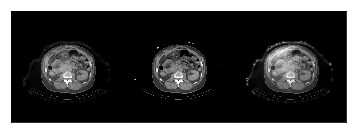

In [231]:
hf.plot_section_auto(fused_img)

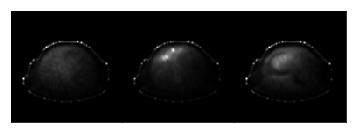

In [242]:
hf.plot_section_auto_1ch(spect_img)